In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn

from scipy.spatial import distance
import seaborn as sns

/home/co-dutt1/.conda/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def disable_module(module):
    for p in module.parameters():
        p.requires_grad = False
        
def enable_module(module):
    for p in module.parameters():
        p.requires_grad = True


def check_tunable_params(model, verbose=True):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if(verbose):
                print(name)
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.5f}"
    )

    return trainable_params, all_param

def create_mapping(model, vector):
    mapping = {}
    i = 0

    for name_p,p in model.named_parameters():
        if '.attn.' in name_p or 'attention' in name_p:
            mapping[name_p] = vector[i]
            i += 1
        else:
            p.requires_grad = False
            
    return mapping

def sort_dict(dict, descending=False):
    sorted_dict = dict(sorted(dict.items(), key=lambda item: item[1], reverse=descending))
    
    return sorted_dict

def get_modules_from_vector(vector, model):
    trainable_blocks = []
    frozen_blocks = []
    
    trainable_blocks = np.where(np.array(vector) == 1)
    frozen_blocks = np.where(np.array(vector) == 0)
    
    return trainable_blocks, frozen_blocks

def get_model_for_bitfit(model):
    trainable_components = ['bias', 'pooler.dense.bias', 'head'] 

    # Disale all the gradients
    for param in model.parameters():
        param.requires_grad = False 
      
    vector = []

    for name, param in model.named_parameters():
        for component in trainable_components:
            if component in name:
                vector.append(1)
                param.requires_grad = True
                break
    
    return vector

def enable_from_vector(vector, model):
    print("Vector: ", vector)
    
    disable_module(model)
    
    for idx, block in enumerate(model.blocks): 
    
        if(vector[idx] == 1):
            print("Enabling attention in Block {}".format(idx))
            enable_module(block.attn)
        else:
            #print("Disabling attention in Block {}".format(idx))
            disable_module(block.attn)
            
def create_best_worst_vector(best_df, worst_df):
    best_vector = np.array([0]*12*4)

    for i in range(len(best_df)):
        vector_path = best_df['Vector Path'][i]
        vector = np.load(vector_path)
        best_vector += vector

    worst_vector = np.array([0]*12*4)

    for i in range(len(worst_df)):
        vector_path = worst_df['Vector Path'][i]
        vector = np.load(vector_path)
        worst_vector += vector
        
    return best_vector, worst_vector
            
def create_block_wise_count(best_vector, worst_vector):
    best_block_wise_count = {}
    block_idx = 0

    for i in range(0, len(best_vector), 4):

        best_block_wise_count['Block {}'.format(block_idx)] = best_vector[i:i+4]
        block_idx += 1

    worst_block_wise_count = {}
    block_idx = 0

    for i in range(0, len(worst_vector), 4):

        worst_block_wise_count['Block {}'.format(block_idx)] = worst_vector[i:i+4]
        block_idx += 1
        
    return best_block_wise_count, worst_block_wise_count

# All Datasets

In [10]:
base_path = '/home/co-dutt1/rds/hpc-work/Layer-Masking/'

dataset = 'breastUS'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
df_breastUS = pd.read_csv(csv)

dataset = 'fitzpatrick'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
df_fitzpatrick = pd.read_csv(csv)

dataset = 'HAM10000'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
df_ham10k = pd.read_csv(csv)

# dataset = 'smdg'
# model = 'vit_base_ssl'
# csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
# df_smdg = pd.read_csv(csv)

dataset = 'retinopathy'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
df_retinopathy = pd.read_csv(csv)

dataset = 'CIFAR10'
model = 'vit_base_ssl'
csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
df_CIFAR10 = pd.read_csv(csv)

# dataset = 'CIFAR100'
# model = 'vit_base_ssl'
# csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
# df_CIFAR100 = pd.read_csv(csv)

# dataset = 'pneumonia'
# model = 'vit_base_ssl'
# csv = base_path + model + '/' + dataset + '/tune_attention_random_' + model + '_0.0001.csv'
# df_pneumonia = pd.read_csv(csv)

#all_datasets = ['breastUS', 'fitzpatrick', 'HAM10000', 'smdg', 'retinopathy', 'CIFAR10']
all_datasets = ['breastUS', 'fitzpatrick', 'HAM10000', 'retinopathy', 'CIFAR10']
#all_datasets = ['breastUS', 'fitzpatrick', 'HAM10000', 'smdg', 'retinopathy', 'CIFAR10', 'CIFAR100', 'pneumonia']

all_dfs = [df_breastUS, df_fitzpatrick, df_ham10k, df_retinopathy, df_CIFAR10]
#all_dfs = [df_breastUS, df_fitzpatrick, df_ham10k, df_smdg, df_retinopathy, df_CIFAR10, df_CIFAR100, df_pneumonia]

In [11]:
all_best_block_counts = {}
all_worst_block_counts = {}

i = 0

for df in all_dfs:
    print("Selecting the best and worst 10 vectors")
    
    k = 10
    best_df = df.sort_values(by=['Test Acc@1'], ascending=False).head(k).reset_index(drop=True)
    worst_df = df.sort_values(by=['Test Acc@1'], ascending=True).head(k).reset_index(drop=True)
    
    best_vector, worst_vector = create_best_worst_vector(best_df, worst_df)
    
    #print("Best Vector: ", best_vector)
    #print("Worst Vector: ", worst_vector)
    
    best_block_wise_count, worst_block_wise_count = create_block_wise_count(best_vector, worst_vector)
    
    all_best_block_counts[all_datasets[i]] = best_block_wise_count
    all_worst_block_counts[all_datasets[i]] = worst_block_wise_count
    i+=1

Selecting the best and worst 10 vectors
Selecting the best and worst 10 vectors
Selecting the best and worst 10 vectors
Selecting the best and worst 10 vectors
Selecting the best and worst 10 vectors


In [12]:
# Calculating the parameters that were activated in each block for all datasets for best performing vectors

all_best_block_counts['breastUS'], all_best_block_counts['fitzpatrick']

keys_list = ['Block {}'.format(i) for i in range(0,12)]
result_dict_best = {key: np.array([0,0,0,0]) for key in keys_list}

for key in all_best_block_counts.keys():
    d = all_best_block_counts[key]
    
    for k in keys_list:
        result_dict_best[k] += d[k]
        
result_dict_best

{'Block 0': array([18, 20, 21, 18]),
 'Block 1': array([25, 27, 26, 27]),
 'Block 2': array([27, 27, 26, 28]),
 'Block 3': array([25, 21, 25, 16]),
 'Block 4': array([23, 25, 27, 26]),
 'Block 5': array([25, 27, 22, 24]),
 'Block 6': array([26, 29, 25, 17]),
 'Block 7': array([27, 30, 27, 26]),
 'Block 8': array([27, 32, 20, 20]),
 'Block 9': array([22, 22, 27, 23]),
 'Block 10': array([32, 23, 22, 33]),
 'Block 11': array([24, 24, 24, 23])}

In [13]:
# Calculating the parameters that were activated in each block for all datasets for worst performing vectors

keys_list = ['Block {}'.format(i) for i in range(0,12)]
result_dict_worst = {key: np.array([0,0,0,0]) for key in keys_list}

for key in all_worst_block_counts.keys():
    d = all_worst_block_counts[key]
    
    for k in keys_list:
        result_dict_worst[k] += d[k]
        
result_dict_worst

{'Block 0': array([28, 26, 24, 27]),
 'Block 1': array([29, 26, 25, 24]),
 'Block 2': array([24, 25, 23, 18]),
 'Block 3': array([29, 23, 21, 22]),
 'Block 4': array([22, 26, 27, 23]),
 'Block 5': array([25, 20, 24, 20]),
 'Block 6': array([26, 21, 23, 27]),
 'Block 7': array([18, 27, 25, 23]),
 'Block 8': array([24, 22, 25, 26]),
 'Block 9': array([24, 29, 30, 21]),
 'Block 10': array([23, 25, 21, 24]),
 'Block 11': array([24, 21, 20, 28])}

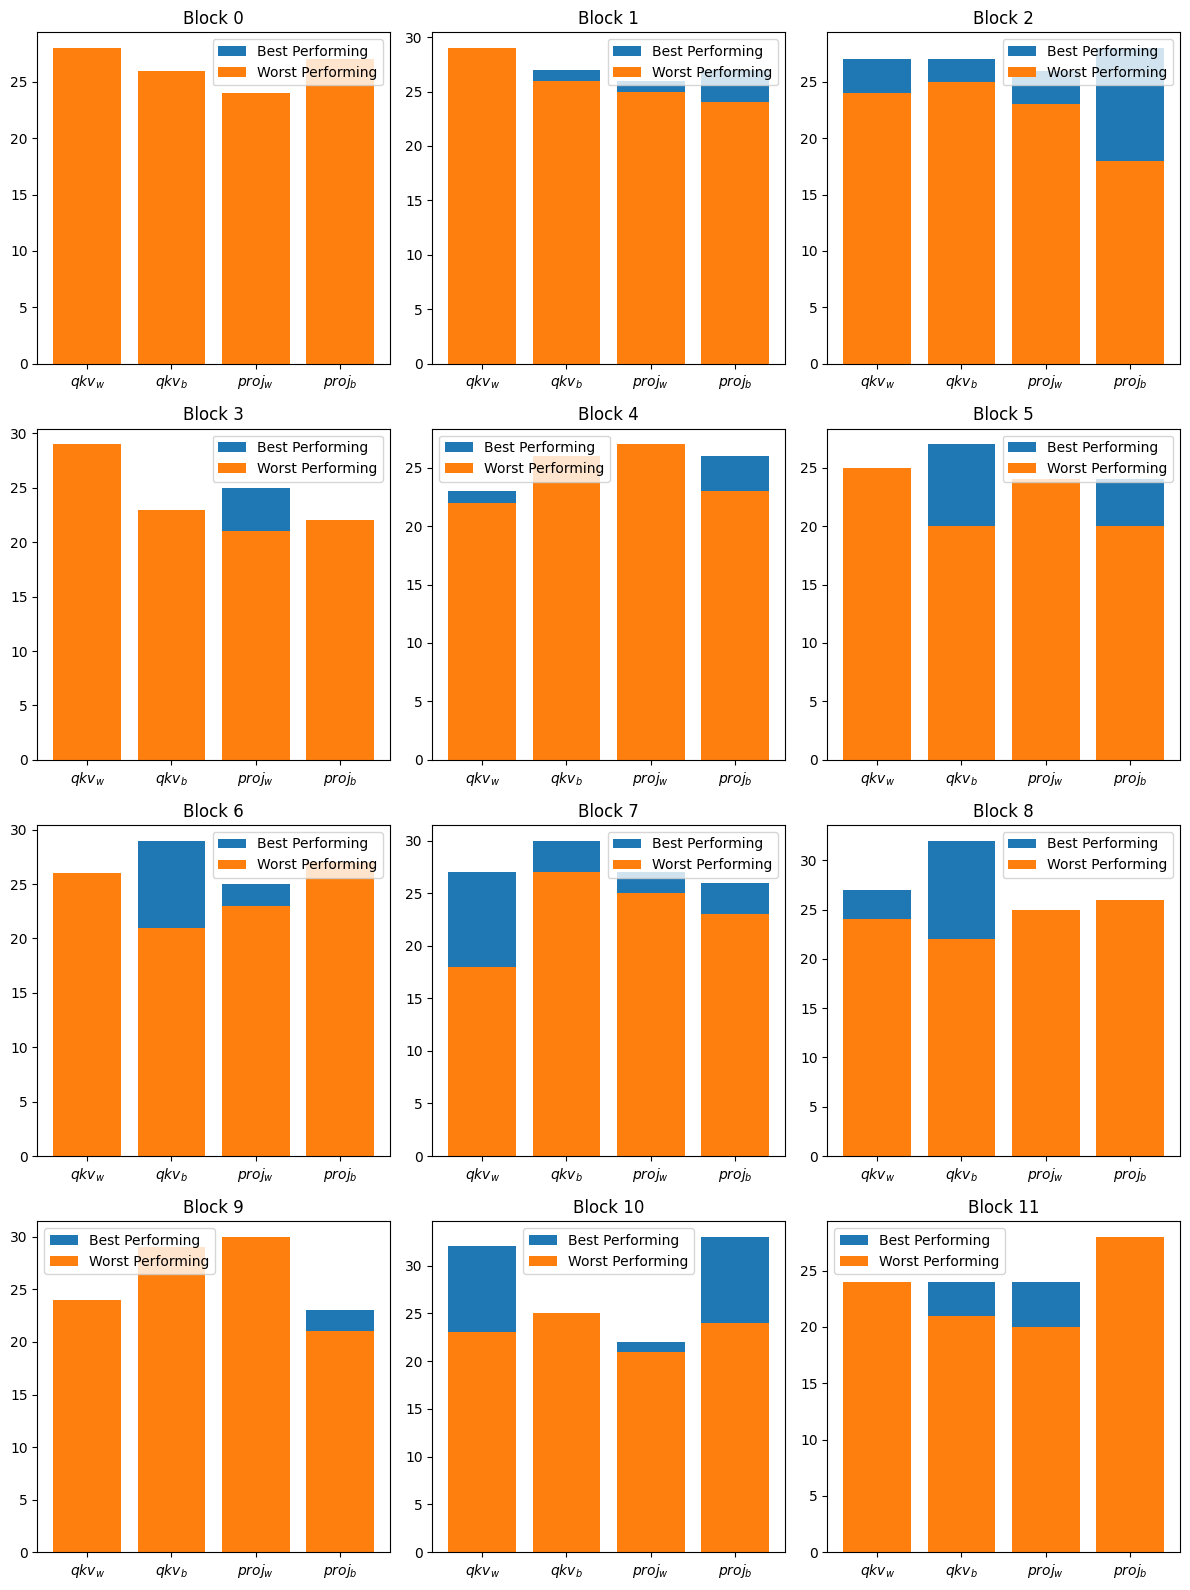

<Figure size 640x480 with 0 Axes>

In [14]:
# Create the subplots
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
xtick_labels = [r'$qkv_w$', r'$qkv_b$', r'$proj_w$', r'$proj_b$']

axs = axs.flatten()
xtick_positions = [0,1,2,3]

for i, all_data in enumerate(zip(result_dict_best.items(), result_dict_worst.items())):
    
    dict1_data = all_data[0]
    dict2_data = all_data[1]
    title = dict1_data[0]
    ax = axs[i]  

    # Create the bar plot
    ax.bar(range(4), dict1_data[1], label='Best Performing')
    ax.bar(range(4), dict2_data[1], label='Worst Performing')
    ax.set_title(title)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels)
    ax.legend()
    #ax.set_xlabel('Parameters')
    #ax.set_ylabel('Selection Count')
    
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('SSL_vit-b_best_worst_parameter_level.png')